In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Lambda, GlobalAveragePooling2D, Dense, Layer, Activation
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.applications import InceptionV3, VGG16
import warnings
warnings.filterwarnings('ignore')

In [2]:
anchor_class_ = 'anchor'
positive_class_ = 'positive'
negative_class_ = 'negative'
training_set_ = 'training'
validation_set_ = 'validation'
core = '/content/drive/MyDrive/Colab Notebooks/Final/data'

THIS SECTION WILL DEFINE THE HYPERPARAMETERS:

In [3]:
BATCH_SIZE_TRAINING = 1
BATCH_SIZE_VALIDATION = 1
EPOCHS = 15
LEARNING_RATE=1e-4
IMG_SHAPE = (224,224,3)
OPTIMIZER = tf.keras.optimizers.RMSprop

In [4]:
# EXPERIMENT CHARLIE - NON_AUGMENTED ORCS
POS_PATH_TRAINING = target_path = os.path.join(core, 'charlie', 'sigma_non_augmented', training_set_, positive_class_)
NEG_PATH_TRAINING = target_path = os.path.join(core, 'charlie', 'sigma_non_augmented', training_set_, negative_class_)
ANC_PATH_TRAINING = target_path = os.path.join(core, 'charlie', 'sigma_non_augmented', training_set_, anchor_class_)
anchor_training = tf.data.Dataset.list_files(ANC_PATH_TRAINING+'/*.jpg').take(-1)
positive_training = tf.data.Dataset.list_files(POS_PATH_TRAINING+'/*.jpg').take(-1)
negative_training = tf.data.Dataset.list_files(NEG_PATH_TRAINING+'/*.jpg').take(-1)

POS_PATH_VAL = target_path = os.path.join(core, 'charlie', 'sigma_non_augmented', validation_set_, positive_class_)
NEG_PATH_VAL = os.path.join(core, 'charlie', 'sigma_non_augmented', validation_set_, negative_class_)
ANC_PATH_VAL = os.path.join(core, 'charlie', 'sigma_non_augmented', validation_set_, anchor_class_)
anchor_val = tf.data.Dataset.list_files(ANC_PATH_VAL+'/*.jpg').take(-1)
positive_val = tf.data.Dataset.list_files(POS_PATH_VAL+'/*.jpg').take(-1)
negative_val = tf.data.Dataset.list_files(NEG_PATH_VAL+'/*.jpg').take(-1)

In [5]:
def preprocess(file_path):
    # Read image from file path
    byte_img = tf.io.read_file(file_path)
    try:
        # Decode the JPEG image
        img = tf.io.decode_jpeg(byte_img)
        img = tf.image.resize(img, (224, 224))
        # img = tf.image.rgb_to_grayscale(img)
        # Normalize image with pixel values between 0 and 1
        img = tf.clip_by_value(img, 0, 255) / 255.0
    except:
        # If decoding or processing fails, return a black image
        img = tf.zeros(IMG_SHAPE, dtype=tf.float32)

    return img

In [6]:
# Create positive and negative dataset pairs
# Each element in positives will look like (anchor_img_path, positive_img_path, float value e.g. 1.0)
# (b'data/sigma_augmented/anchor/J011425.5+002932.fits_colour_sigma.jpg', b'data/sigma_augmented/positive/29feeb48-40be-11ee-a877-ba54a3c54336.jpg', 1.0)
positives = tf.data.Dataset.zip((anchor_training, positive_training, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_training)))))

# (b'data/sigma_augmented/anchor/J072431.5+501052.fits_colour_sigma.jpg', b'data/sigma_augmented/negative/3c9b8dd8-40be-11ee-a877-ba54a3c54336.jpg', 0.0)
negatives = tf.data.Dataset.zip((anchor_training, negative_training, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_training)))))

# Data is the complete dataset of the positive and negative pairs, hence each element will also look like one of the above.
data_training = positives.concatenate(negatives)

# Create positive and negative dataset pairs
# Each element in positives will look like (anchor_img_path, positive_img_path, float value e.g. 1.0)
# (b'data/sigma_augmented/anchor/J011425.5+002932.fits_colour_sigma.jpg', b'data/sigma_augmented/positive/29feeb48-40be-11ee-a877-ba54a3c54336.jpg', 1.0)
positives = tf.data.Dataset.zip((anchor_val, positive_val, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_val)))))

# (b'data/sigma_augmented/anchor/J072431.5+501052.fits_colour_sigma.jpg', b'data/sigma_augmented/negative/3c9b8dd8-40be-11ee-a877-ba54a3c54336.jpg', 0.0)
negatives = tf.data.Dataset.zip((anchor_val, negative_val, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_val)))))

# Data is the complete dataset of the positive and negative pairs, hence each element will also look like one of the above.
data_val = positives.concatenate(negatives)

In [7]:
# The preprocess_twin() function calls preprocess() on the both images in the image pair:
# This in turn completes the preprocess on each image and returns the preprocessed image along with a label.
#   -> preprocess(input_img): anchor image
#   -> preprocess(validation_img)  : validation image
#   -> label: float value representing either a positive or negative pair. i.e. either 1.0 or 0.0

def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [8]:
# Take the first 80% of the data and assigns it to the `train_data` variable.
# Apply the preprocess_twin() function to each element of the `train_data` dataset
#   -> cache the `train_data` dataset in memory. This can improve the performance of training, as the data will not need to be loaded from disk each time it is used.
#   -> Shuffle the `train_data` dataset. This is important to do, as it helps to ensure that the model is not overfitting to the training data.
#   -> Batch the `train_data` dataset into batches of size 16.
#   -> Prefetch the next 8 batches of data.

train_data = (data_training
                .map(preprocess_twin)
                .shuffle(buffer_size=10000)
                .batch(batch_size=BATCH_SIZE_TRAINING, drop_remainder=True)
            )

# Repeat for validation set
val_data = (data_val
                .map(preprocess_twin)
                .shuffle(buffer_size=10000)
                .batch(batch_size=BATCH_SIZE_VALIDATION, drop_remainder=True)
            )

In [9]:
# Prepare data to be fed into SNN
train_images_input = []
train_images_validation = []
train_labels = []

for input_img, validation_img, label in train_data:
    train_images_input.append(input_img)
    train_images_validation.append(validation_img)
    train_labels.append(label)

# Concatenate the three lists into tensors using the `tf.concat()` function.
train_images_input = tf.concat(train_images_input, axis=0)
train_images_validation = tf.concat(train_images_validation, axis=0)
train_labels = tf.concat(train_labels, axis=0)

# Prepare data to be fed into SNN
val_images_input = []
val_images_validation = []
val_labels = []

for input_img, validation_img, label in val_data:
    val_images_input.append(input_img)
    val_images_validation.append(validation_img)
    val_labels.append(label)

# Concatenate the three lists into tensors using the `tf.concat()` function.
val_images_input = tf.concat(val_images_input, axis=0)
val_images_validation = tf.concat(val_images_validation, axis=0)
val_labels = tf.concat(val_labels, axis=0)

In [10]:
# Design SNN based on architecture

def build_cnn():
  input_layer = Input(shape=IMG_SHAPE)

  # AlexNet Architecture
  # x = Conv2D(96, 11, strides=4, padding='same')(input_layer)
  # x = Lambda(tf.nn.local_response_normalization)(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = MaxPool2D(3, strides=2)(x)
  # x = Conv2D(256, 5, strides=4, padding='same')(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = MaxPool2D(3, strides=2)(x)
  # x = Conv2D(384, 3, strides=4, padding='same')(x)
  # x = Activation('relu')(x)
  # x = Conv2D(384, 3, strides=4, padding='same')(x)
  # x = Activation('relu')(x)
  # x = Conv2D(256, 3, strides=4, padding='same')(x)
  # x = Activation('relu')(x)
  # x = Flatten()(x)
  # x = Dense(4096, activation='relu')(x)
  # x = Dense(4096, activation='relu')(x)
  # x = Dense(4096, activation='sigmoid')(x)

  # VGG16 Architecture
  # backbone = VGG16(include_top=False)(input_layer)
  # x = layers.Flatten()(backbone)
  # x = layers.Dense(4096, activation='sigmoid')(x)

  # Inception Architecture
  backbone = InceptionV3(include_top=False)(input_layer)
  x = layers.Flatten()(backbone)
  x = layers.Dense(4096, activation='sigmoid')(x)

  return Model(inputs=input_layer, outputs=x)

In [11]:
# The `call()` method of the `L1Dist` layer computes the L1 distance between the `anchor_embedding` and `validation_embedding` tensors.
# The `call()` method first computes the absolute difference between the corresponding elements of the two tensors.
# Then, the `call()` method sums the absolute differences to compute the L1 distance.
# The `L1Dist` layer can be used to measure the similarity between two data points.
# The layer can be used in a variety of different applications, such as image recognition.

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, anchor_embedding, validation_embedding):
        return tf.math.abs(anchor_embedding - validation_embedding)

In [12]:
def make_siamese_model():
    embedding = build_cnn()

    # Anchor image input in the network
    anchor_image = Input(name='anchor_img', shape=IMG_SHAPE)

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=IMG_SHAPE)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(anchor_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[anchor_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [13]:
snn = make_siamese_model()

In [14]:
snn.compile(optimizer=OPTIMIZER(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = snn.fit([train_images_input, train_images_validation], train_labels, epochs=EPOCHS, validation_split=0.3)

Epoch 1/15
1/1 [==============================] - 50s 50s/step - loss: 0.7876 - accuracy: 0.2500 - val_loss: 0.7154 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 19s 19s/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 0.8544 - val_accuracy: 0.0000e+00
Epoch 3/15
1/1 [==============================] - 20s 20s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8738 - val_accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 19s 19s/step - loss: 4.3747e-04 - accuracy: 1.0000 - val_loss: 0.8718 - val_accuracy: 0.0000e+00
Epoch 5/15
1/1 [==============================] - 18s 18s/step - loss: 3.4832e-04 - accuracy: 1.0000 - val_loss: 0.8603 - val_accuracy: 0.0000e+00
Epoch 6/15
1/1 [==============================] - 18s 18s/step - loss: 2.9738e-04 - accuracy: 1.0000 - val_loss: 0.8451 - val_accuracy: 0.0000e+00
Epoch 7/15
1/1 [==============================] - 19s 19s/step - loss: 2.6209e-04 - accuracy: 1.0000 - val_loss: 0.8382 - val_accuracy

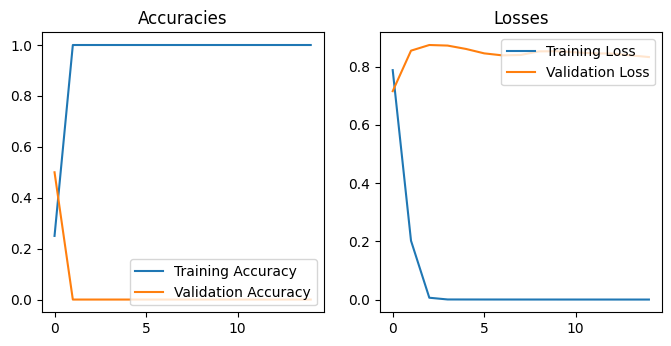

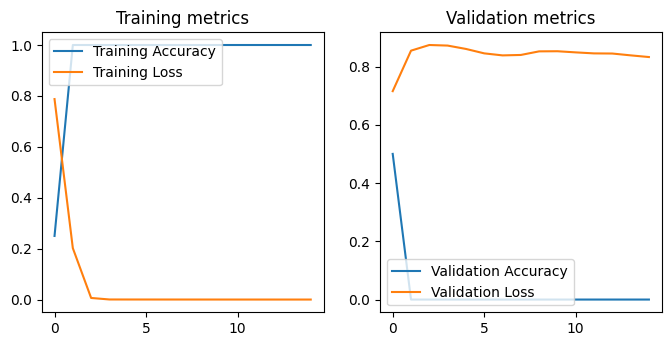

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracies')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Losses')

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper left')
plt.title('Training metrics')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Validation metrics')
plt.show()

In [17]:
test_metrics = snn.evaluate([val_images_input, val_images_validation], val_labels)

print("Test Loss:", test_metrics[0])
print("Test Accuracy:", test_metrics[1])

1/1 [==============================] - 1s 795ms/step - loss: 0.7725 - accuracy: 0.5000
Test Loss: 0.7724921107292175
Test Accuracy: 0.5


In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [19]:
# Predict using the model
y_pred = snn.predict([val_images_input, val_images_validation])
predicted_labels = np.round(y_pred).flatten()  # Assuming you're doing binary classification
true_labels = val_labels.numpy()

# Compute precision and recall
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 4s 4s/step


In [20]:
# Compute ROC-AUC score and plot ROC curve
roc_auc = roc_auc_score(true_labels, y_pred)
fpr, tpr, thresholds = roc_curve(true_labels, y_pred)

In [21]:
# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC-AUC Score: {roc_auc:.4f}')

Precision: 0.0000
Recall: 0.0000
Confusion Matrix:
[[1 0]
 [1 0]]
ROC-AUC Score: 0.0000


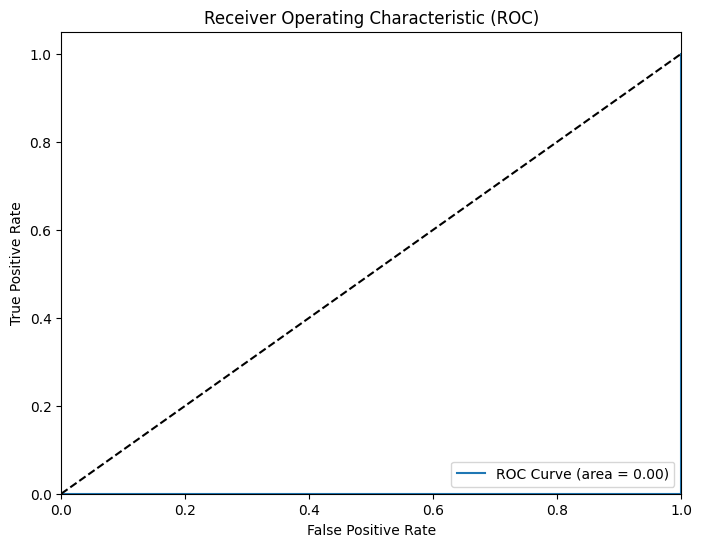

In [22]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()